<a href="https://colab.research.google.com/github/jgleaves7/MultiPRIDE_2026_es/blob/main/01_multipride2025_JorgeGleaves_INFOTEC_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MultiPRIDE Evalita 2026
## Task description
With this task, we invite participants to explore features and issues related to reclaimed
language in the LGBTQ+ community. In particular, we suggest participants to focus
on both the textual content of the inputs (such as arguments, slurs, denigratory words,
self-labeling, figures of speech), and the contextual information that can be inferred from
the users’ profile (when available), such as their being part of the LGBTQ+ community
or the political orientation. We propose a binary classification task, in which systems
must classify whether a term related to LGBTQ+ context in a sentence is used with a
reclamatory intent or not. Overall, we propose two different tasks:

## Dependencies

In [3]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup

from google.colab import drive

In [4]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Phase 2: Data wrangling

## Data load

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
filepath = '/content/drive/MyDrive/MultiPRIDE_2026/multipride_data/train_es.csv'
df = pd.read_csv(filepath)
df.head()

,id,text,bio,label,lang
0,es_1850,28 de Junio - Día Internacional del Orgullo LG...,Doblajes Para Videojuegos que nunca tuvieron D...,0,es
1,es_773,"@USER no me gusta la Montero, por su apoyo a l...","Activista, sindicalista, madre y parte de la R...",0,es
2,es_1899,Es la semana del #GayPride y la dedicaré al #Q...,Pintor daltónico que habla de arte. Confundo e...,0,es
3,es_685,@USER @USER @USER A la carles vais los #TRANSF...,mujer Algemesí Valencia Telegram @USER\n+34 62...,0,es
4,es_1717,"Hoy a las 00:10 en TVE2, estreno del documenta...",Comunidad LGTBI+ sin ánimo de lucro. Reivindic...,0,es


In [7]:
def count_labels (df):
  return df['label'].value_counts()

In [8]:
count_labels (df)

,count
label,
0,743
1,133


In [9]:
# REMOVE NaN VALUES AND EMPTY STRINGS:
df.dropna(inplace=True)

blanks = []  # start with an empty list

for i,id,txt,bio,lb,lg in df.itertuples():  # iterate over the DataFrame
    if type(txt)==str:            # avoid NaN values
        if txt.isspace():         # test 'text' column for whitespace
            blanks.append(i)     # add matching index numbers to the list

df.drop(blanks, inplace=True)

In [10]:
count_labels (df)

,count
label,
0,703
1,124


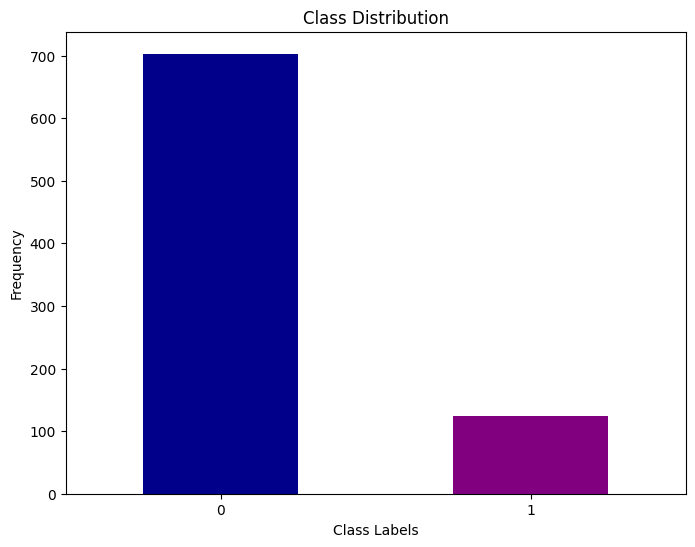

Class Percentages:
 label
0    85.006046
1    14.993954
Name: count, dtype: float64


In [11]:
import matplotlib.pyplot as plt
class_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['darkblue', 'purple'])
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

total = len(df)
percentages = (class_counts / total) * 100
print("Class Percentages:\n", percentages)

###Cleaning

Define a function with beutiful soup to delete mentions as "@" , links and blank spaces. Additionaly is keeped only text characters.

In [12]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet).get_text()
    # Eliminar el @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Eliminar los links de la URL
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Conservamos solamente las letras
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Eliminamos espacios en blanco adicionales
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [13]:
data_clean = [clean_tweet(tweet) for tweet in df.text]

In [14]:
data_clean[0:5]

[' de Junio D a Internacional del Orgullo LGTBI. Viva el amor Libre!!! lgtb lgtbiq lgtbi amorlibre loveislove orgullogay pride queer love amor libertad gay yaoi visibilidad besos kiss lovewins orgullo respeto lucha homosexual doblajespain URL',
 ' no me gusta la Montero por su apoyo a la ley Trans ignorar a las feministas de base fomentar la agenda Queer etc pero lo de Juana Rivas es un acoso y derribo a una mujer que lucha por sus hijos.. URL',
 'Es la semana del GayPride y la dedicar al QueerArt entendido como arte de tem tica queer o realizado por artistas LGTBIQ . El tri ngulo invertido rosa tiene un gran significado. Monumento contra la homofobia . Ciudad de Sitges Catalu a Espa a. Sigue URL',
 ' A la carles vais los TRANSFOBIA Unidas podemos Ha y es un hombre no una ni a ..y necesita un pene para su sexualidad como todos los hombres leytrans URL',
 'Hoy a las en TVE estreno del documental C rceles de Bolleras orgullo visibilidad diversidad lesbianas LGTBI amor ternura orgullodequ

In [15]:
data_labels = df.label

In [16]:
#Undersampling: Randomly removes samples from the majority class.

!pip install imblearn

In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features (text) and target (label)
X = data_clean
y = data_labels

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Convert X_resampled back to a 1D array/list if needed for further processing
X_resampled = X_resampled.flatten().tolist()

print("Undersampling applied. New feature and label arrays created.")

Undersampling applied. New feature and label arrays created.


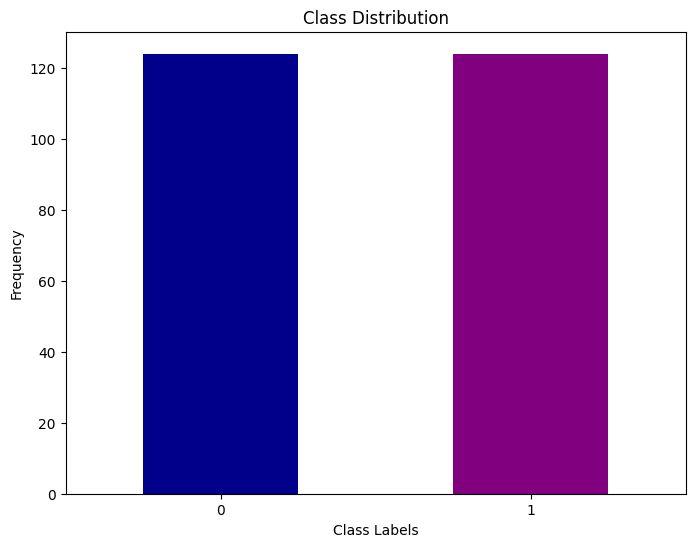

Class Percentages:
 label
0    50.0
1    50.0
Name: count, dtype: float64


In [18]:
class_counts = y_resampled.value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['darkblue', 'purple'])
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

total = len(X_resampled)
percentages = (class_counts / total) * 100
print("Class Percentages:\n", percentages)

In [19]:
#Check Review
X_resampled[0]

' En mi agenda como LGB solo como punto en com n he escrito como punto com n no escrib solo me preocupe eso est la lucha contra la ideolog a de g nero Queer Ley Trans etc. Pero primero deber an no cancelar el activismo en este sentido de LGB que no son de izquierdas.'

### Tokenization

In [20]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    X_resampled, target_vocab_size=2**16
)



In [21]:
data_inputs = [tokenizer.encode(sentence) for sentence in X_resampled]

In [22]:
data_inputs[0]

[2696,
 74,
 42,
 2122,
 36,
 378,
 92,
 36,
 459,
 10,
 618,
 8,
 556,
 585,
 36,
 459,
 618,
 8,
 14,
 1658,
 92,
 26,
 1087,
 583,
 48,
 4,
 63,
 58,
 4,
 245,
 3,
 1,
 84,
 123,
 56,
 68,
 66,
 580,
 2,
 154,
 1082,
 603,
 179,
 14,
 1941,
 9,
 211,
 10,
 72,
 924,
 1,
 378,
 6,
 14,
 82,
 1,
 1429,
 2710]

### Padding

In [23]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [24]:
num_resampled_samples = len(data_inputs)
num_test_samples = 12

# Generate unique random indices for the test set from the range of the resampled data
test_idx = np.random.choice(num_resampled_samples, num_test_samples, replace=False)

test_inputs = data_inputs[test_idx]
# Use y_resampled for the labels, as it corresponds to the undersampled data
test_labels = y_resampled.iloc[test_idx]

# To get train_inputs and train_labels, remove the selected test_idx from the full dataset
# Using boolean masking to create training indices for both inputs and labels
all_indices = np.arange(num_resampled_samples)
train_idx_mask = np.ones(num_resampled_samples, dtype=bool)
train_idx_mask[test_idx] = False
train_idx = all_indices[train_idx_mask]

train_inputs = data_inputs[train_idx]
train_labels = y_resampled.iloc[train_idx]

In [42]:
num_resampled_samples = len(data_inputs)
num_test_samples = num_resampled_samples

# Generate unique random indices for the test set from the range of the resampled data
test_idx = np.random.choice(num_resampled_samples, num_test_samples, replace=False)

test_inputs_2 = data_inputs[test_idx]
# Use y_resampled for the labels, as it corresponds to the undersampled data
test_labels_2 = y_resampled.iloc[test_idx]

## Phase 3: Model Build

In [25]:
class DCNN(tf.keras.Model):

    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=True,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()

        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # (batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # (batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # (batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training=training) # Fixed this line
        output = self.last_dense(merged)

        return output

## Phase 4: Training and configuration

### Configuration

In [26]:
VOCAB_SIZE = tokenizer.vocab_size # 65540

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 # or len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5

### Training

In [27]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [28]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

###Create Checkpoint

In [29]:
checkpoint_path = "../content/drive/MyDrive/MultiPRIDE_2026/ckpt_ES/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último checkpoint restaurado!!")

In [30]:
history = Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.4896 - loss: 0.6979
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8839 - loss: 0.6473
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9199 - loss: 0.5729 
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9850 - loss: 0.4457 
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9882 - loss: 0.2824 


'../content/drive/MyDrive/MultiPRIDE_2026/ckpt_ES/ckpt-1'

## Phase 5: Evaluation

In [31]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - accuracy: 0.9167 - loss: 0.4192
[0.4191591739654541, 0.9166666865348816]


In [32]:
def get_prediction(sentence):
    tokens = tokenizer.encode(sentence)
    inputs = tf.expand_dims(tokens, 0)

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print("Salida del modelo: {}\nSentimiento predicho: Negativo.".format(
            output))
    elif sentiment == 1:
        print("Salida del modelo: {}\nSentimiento predicho: Positivo.".format(
            output))

In [33]:
get_prediction("Estoy orgulloso de ser Gay. Es momento de levantar nuestras voces")

Salida del modelo: [[0.6119099]]
Sentimiento predicho: Positivo.


In [34]:
Dcnn.summary()

Model: "dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 61, 200)        │       584,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 100)        │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 59, 100)        │        60,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 58, 100)        │        80,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,524,841 (9.63 MB)

 Trainable params: 841,613 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,683,228 (6.42 MB)

dict_keys(['accuracy', 'loss'])


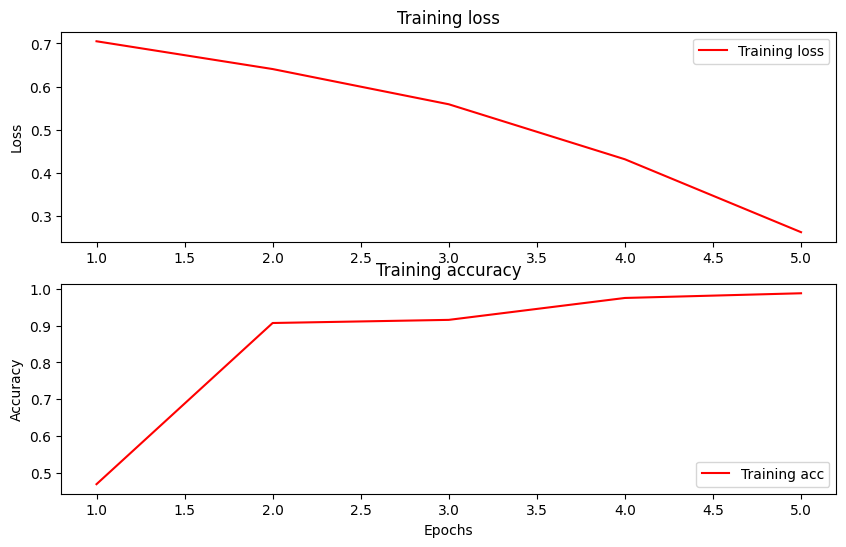

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [48]:
import pandas as pd

# Get raw predictions from the Dcnn model for the test inputs
raw_predictions = Dcnn(test_inputs, training=False)

# Convert raw predictions (probabilities) to binary labels (0 or 1)
# If probability >= 0.5, predict 1, otherwise predict 0
predicted_labels = tf.where(raw_predictions >= 0.5, 1, 0).numpy().flatten()

# Retrieve the original 'id' values corresponding to the test_labels
# test_labels' index holds the original df indices from which these samples were drawn
original_ids_for_test = df.loc[test_labels.index]['id']

# Create a DataFrame for the output file
output_df = pd.DataFrame({
    'id': original_ids_for_test,
    'label': predicted_labels,
    'lang': 'es'
})

# Display the first few rows of the output DataFrame
print("Generated Output DataFrame Head:")
print(output_df.head())

# Save the DataFrame to a TSV file
output_file_path = '/content/drive/MyDrive/MultiPRIDE_2026/predictions_es.tsv'
output_df.to_csv(output_file_path, sep='\t', index=False)

print(f"Output file saved to {output_file_path}")

Generated Output DataFrame Head:
          id  label lang
193   es_103      1   es
102   es_244      0   es
51   es_1564      0   es
239   es_255      1   es
220  es_1323      1   es
Output file saved to /content/drive/MyDrive/MultiPRIDE_2026/predictions_es.tsv


# Full run
Generate predictions for the entire original `df` DataFrame. First, clean the `df['text']` column using the `clean_tweet` function. Then, tokenize the cleaned text using the existing `tokenizer` and pad it to `MAX_LEN` to create `full_df_inputs`. Use the `Dcnn` model to get predictions from `full_df_inputs`, converting the raw probabilities to binary labels (0 or 1). Finally, create a pandas DataFrame with 'id' from the original `df`, the generated 'label', and 'lang' set to 'es'. Save this DataFrame to a TSV file named "predictions_full_df.tsv" in the path `/content/drive/MyDrive/MultiPRIDE_2026/`.

## Prepare Full DataFrame Inputs

### Subtask:
Clean the 'text' column of the entire original `df` using the `clean_tweet` function. Then, tokenize these cleaned texts using the existing `tokenizer` and pad them to `MAX_LEN` to create the input format required by the DCNN model. These will be named `full_df_inputs`.


**Reasoning**:
The subtask requires cleaning the 'text' column of the original DataFrame, tokenizing the cleaned texts, and then padding them to `MAX_LEN`. This can be achieved in a single code block by applying the `clean_tweet` function, encoding with the existing tokenizer, and finally padding the sequences.



In [46]:
full_df_clean_text = [clean_tweet(text) for text in df.text]
full_df_tokenized_text = [tokenizer.encode(sentence) for sentence in full_df_clean_text]
full_df_inputs = tf.keras.preprocessing.sequence.pad_sequences(full_df_tokenized_text,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

print("Full DataFrame inputs (full_df_inputs) prepared successfully.")

Full DataFrame inputs (full_df_inputs) prepared successfully.


**Reasoning**:
Now that the `full_df_inputs` are prepared, the next step is to use the trained `Dcnn` model to generate predictions for the entire original DataFrame, convert these predictions to binary labels, and then create and save the output DataFrame as a TSV file.



In [47]:
raw_predictions_full_df = Dcnn(full_df_inputs, training=False)
predicted_labels_full_df = tf.where(raw_predictions_full_df >= 0.5, 1, 0).numpy().flatten()

output_df_full = pd.DataFrame({
    'id': df['id'],
    'label': predicted_labels_full_df,
    'lang': 'es'
})

print("Generated Full Output DataFrame Head:")
print(output_df_full.head())

output_file_path_full = '/content/drive/MyDrive/MultiPRIDE_2026/predictions_full_df.tsv'
output_df_full.to_csv(output_file_path_full, sep='\t', index=False)

print(f"Full predictions file saved to {output_file_path_full}")

Generated Full Output DataFrame Head:
        id  label lang
0  es_1850      0   es
1   es_773      0   es
2  es_1899      0   es
3   es_685      0   es
4  es_1717      1   es
Full predictions file saved to /content/drive/MyDrive/MultiPRIDE_2026/predictions_full_df.tsv


In [50]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Ensure true_labels_full_df and predicted_labels_full_df are available
# true_labels_full_df was defined as df['label']
# predicted_labels_full_df was created in cell eb583357

# Calculate F1 score (already done but including for completeness in the report)
f1 = f1_score(true_labels_full_df, predicted_labels_full_df)

# Calculate Accuracy
accuracy = accuracy_score(true_labels_full_df, predicted_labels_full_df)

# Generate and print the classification report
report = classification_report(true_labels_full_df, predicted_labels_full_df, target_names=['Class 0', 'Class 1'])

print("--- Full Metrics Report (on original df) ---")
print(f"Overall F1 Score: {f1:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)


--- Full Metrics Report (on original df) ---
Overall F1 Score: 0.6123
Overall Accuracy: 0.8102

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.78      0.87       703
     Class 1       0.44      1.00      0.61       124

    accuracy                           0.81       827
   macro avg       0.72      0.89      0.74       827
weighted avg       0.92      0.81      0.84       827



## Final Task

### Subtask:
Confirm the successful creation and saving of the output TSV file with predictions for the entire original DataFrame.


## Summary:

### Q&A
The successful creation and saving of the output TSV file with predictions for the entire original DataFrame has been confirmed. The file "predictions_full_df.tsv" was successfully generated and saved to `/content/drive/MyDrive/MultiPRIDE_2026/`.

### Data Analysis Key Findings
*   The `df['text']` column was successfully cleaned using `clean_tweet`, tokenized with the existing `tokenizer`, and padded to `MAX_LEN` to create `full_df_inputs`, which were confirmed to be "prepared successfully."
*   Predictions were generated using the `Dcnn` model from `full_df_inputs`, converted to binary labels (0 or 1) using a 0.5 threshold, and combined with 'id' from the original DataFrame and 'lang' set to 'es' into `output_df_full`. This DataFrame was confirmed to be "successfully generated."
*   The `output_df_full` DataFrame was successfully saved as a TSV file named "predictions_full_df.tsv" to the specified path `/content/drive/MyDrive/MultiPRIDE_2026/`.

### Insights or Next Steps
*   The generated TSV file containing predictions can now be used for submission, further analysis, or integration into downstream processes.
*   Consider evaluating the performance of these predictions against a held-out test set or ground truth if available, to assess the model's generalization capabilities.
